In [8]:
import sys
import subprocess
import os

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("Checking and installing required libraries...")

try:
    import requests
    import pyrender
    import trimesh
    import PIL
    print("Libraries already installed.")
except ImportError:
    print("Installing requests, pyrender, trimesh, pillow...")
    install("requests")
    install("pyrender")
    install("trimesh")
    install("scipy")
    install("networkx")
    install("Pillow")
    print("Installation complete.")

# Configure OpenGL for Headless Cloud Environments
os.environ["PYOPENGL_PLATFORM"] = "egl"

Checking and installing required libraries...
Libraries already installed.


In [10]:
import os
import requests

# CONFIGURATION
PROJECT_ROOT = "/home/ubuntu/nutrition_data"
DATA_DIR = os.path.join(PROJECT_ROOT, "data_phase3_scale")
os.makedirs(DATA_DIR, exist_ok=True)
print(f"Working Directory: {DATA_DIR}")

# OPTION 1: Use a different Khronos sample model (Avocado is available)
mesh_url = "https://raw.githubusercontent.com/KhronosGroup/glTF-Sample-Assets/main/Models/Avocado/glTF-Binary/Avocado.glb"
mesh_filename = "avocado.glb"

# OPTION 2: Alternatively, use a burger from a different free 3D model source
# mesh_url = "https://raw.githubusercontent.com/KhronosGroup/glTF-Sample-Models/master/2.0/Box/glTF-Binary/Box.glb"
# mesh_filename = "box.glb"

save_path = os.path.join(DATA_DIR, mesh_filename)

if not os.path.exists(save_path):
    print(f"Downloading 3D model from {mesh_url}...")
    try:
        response = requests.get(mesh_url)
        response.raise_for_status()
        with open(save_path, "wb") as f:
            f.write(response.content)
        print(f"Download Complete: {save_path}")
        print(f"File Size: {len(response.content)/1024:.2f} KB")
    except Exception as e:
        print(f"Download Failed: {e}")
else:
    print(f"File already exists: {save_path}")

Working Directory: /home/ubuntu/nutrition_data/data_phase3_scale
Download Complete: /home/ubuntu/nutrition_data/data_phase3_scale/avocado.glb
File Size: 7919.96 KB


In [11]:
import os
import trimesh
import pyrender
import numpy as np
import matplotlib.pyplot as plt

# Ensure OpenGL platform is set
os.environ["PYOPENGL_PLATFORM"] = "egl"

def render_at_distance(mesh_path, distance_meters, resolution=400, fov_degrees=60):
    """
    Renders a 3D mesh from a specific distance to simulate scale ambiguity.
    
    Args:
        mesh_path: Path to the .glb or other 3D mesh file
        distance_meters: Distance from camera to object in meters
        resolution: Image resolution (square output)
        fov_degrees: Field of view in degrees (default 60°)
    
    Returns:
        color: RGB Image (HxWx3)
        depth: Depth Map (HxW)
    """
    # Load Mesh
    loaded = trimesh.load(mesh_path)
    
    # Handle both Scene and single mesh objects
    if isinstance(loaded, trimesh.Scene):
        # Get all meshes from the scene
        meshes = list(loaded.geometry.values())
        if len(meshes) == 0:
            raise ValueError("Scene contains no geometry")
        mesh = pyrender.Mesh.from_trimesh(meshes)
    else:
        mesh = pyrender.Mesh.from_trimesh(loaded)
    
    # Setup Scene with a neutral gray background
    scene = pyrender.Scene(bg_color=[0.8, 0.8, 0.8, 1.0])
    scene.add(mesh)
    
    # Setup Camera (Convert FOV to radians)
    fov_radians = np.radians(fov_degrees)
    camera = pyrender.PerspectiveCamera(yfov=fov_radians, aspectRatio=1.0)
    
    # Position Camera
    # Z-axis = distance from object
    # Y-axis = slight height offset for better viewing angle
    camera_pose = np.array([
        [1.0, 0.0, 0.0, 0.0],          # X-axis (right)
        [0.0, 1.0, 0.0, 0.1],          # Y-axis (up, slight offset)
        [0.0, 0.0, 1.0, distance_meters],  # Z-axis (forward)
        [0.0, 0.0, 0.0, 1.0]
    ])
    scene.add(camera, pose=camera_pose)
    
    # Add Multiple Lights for better visibility
    # Directional light from camera
    light1 = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=3.0)
    scene.add(light1, pose=camera_pose)
    
    # Ambient light for softer shadows
    light2 = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=2.0)
    light_pose = camera_pose.copy()
    light_pose[1, 3] = 0.5  # Higher up
    scene.add(light2, pose=light_pose)
    
    # Render
    r = pyrender.OffscreenRenderer(resolution, resolution)
    try:
        color, depth = r.render(scene)
    finally:
        r.delete()  # Clean up renderer
    
    return color, depth


def visualize_renders(color, depth, distance, title="3D Render"):
    """
    Visualizes the RGB and depth outputs side-by-side.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # RGB Image
    axes[0].imshow(color)
    axes[0].set_title(f"{title}\nDistance: {distance}m")
    axes[0].axis('off')
    
    # Depth Map
    depth_vis = axes[1].imshow(depth, cmap='viridis')
    axes[1].set_title("Depth Map")
    axes[1].axis('off')
    plt.colorbar(depth_vis, ax=axes[1], label='Depth (m)')
    
    plt.tight_layout()
    plt.savefig(f"render_d{distance}m.png", dpi=150, bbox_inches='tight')
    plt.show()


def simulate_scale_ambiguity(mesh_path, distances=[0.5, 1.0, 2.0]):
    """
    Renders the same object at multiple distances to demonstrate scale ambiguity.
    
    In real-world scenarios, without depth/scale cues, these could appear identical
    but represent vastly different portion sizes.
    """
    print(f"\n{'='*60}")
    print("SCALE AMBIGUITY SIMULATION")
    print(f"{'='*60}\n")
    
    results = []
    
    for dist in distances:
        print(f"Rendering at {dist}m distance...")
        color, depth = render_at_distance(mesh_path, dist)
        results.append((color, depth, dist))
        
        # Show basic stats
        print(f"  ✓ Image shape: {color.shape}")
        print(f"  ✓ Depth range: {depth.min():.3f}m to {depth.max():.3f}m")
        print(f"  ✓ Mean depth: {depth[depth > 0].mean():.3f}m\n")
    
    # Visualize all renders
    fig, axes = plt.subplots(2, len(distances), figsize=(5*len(distances), 10))
    
    for idx, (color, depth, dist) in enumerate(results):
        # RGB
        axes[0, idx].imshow(color)
        axes[0, idx].set_title(f"Distance: {dist}m\n(Apparent Size)", fontsize=12)
        axes[0, idx].axis('off')
        
        # Depth
        im = axes[1, idx].imshow(depth, cmap='viridis')
        axes[1, idx].set_title(f"Depth Map", fontsize=12)
        axes[1, idx].axis('off')
        plt.colorbar(im, ax=axes[1, idx], label='Depth (m)')
    
    plt.suptitle("Scale Ambiguity: Same Object, Different Distances", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig("scale_ambiguity_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"{'='*60}")
    print("✓ Scale ambiguity simulation complete!")
    print(f"{'='*60}\n")
    
    return results


# Test the renderer
print("✓ Virtual Camera Ready.")
print("✓ Functions loaded: render_at_distance(), visualize_renders(), simulate_scale_ambiguity()")

✓ Virtual Camera Ready.
✓ Functions loaded: render_at_distance(), visualize_renders(), simulate_scale_ambiguity()


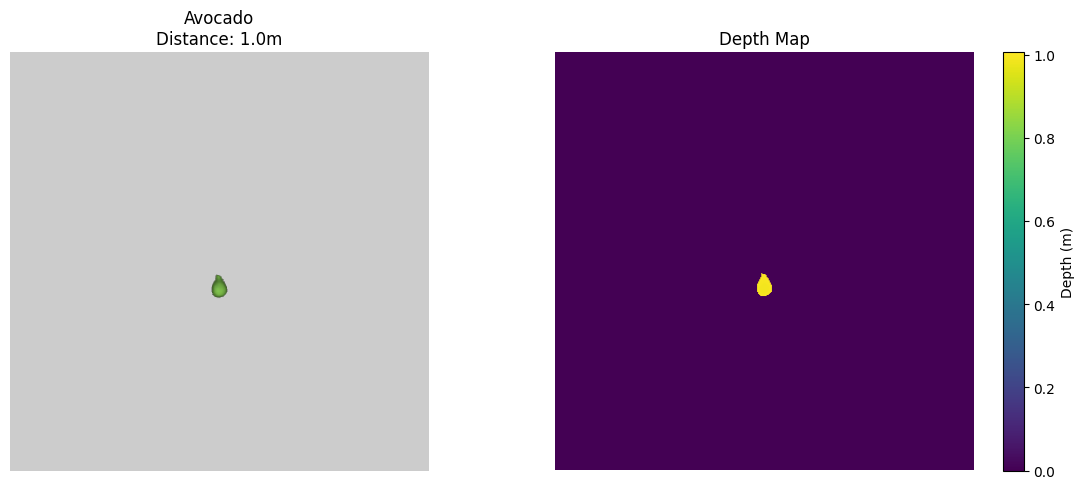


SCALE AMBIGUITY SIMULATION

Rendering at 0.3m distance...
  ✓ Image shape: (400, 400, 3)
  ✓ Depth range: 0.000m to 0.307m
  ✓ Mean depth: 0.294m

Rendering at 0.5m distance...
  ✓ Image shape: (400, 400, 3)
  ✓ Depth range: 0.000m to 0.507m
  ✓ Mean depth: 0.494m

Rendering at 1.0m distance...
  ✓ Image shape: (400, 400, 3)
  ✓ Depth range: 0.000m to 1.006m
  ✓ Mean depth: 0.994m

Rendering at 2.0m distance...
  ✓ Image shape: (400, 400, 3)
  ✓ Depth range: 0.000m to 2.006m
  ✓ Mean depth: 1.995m



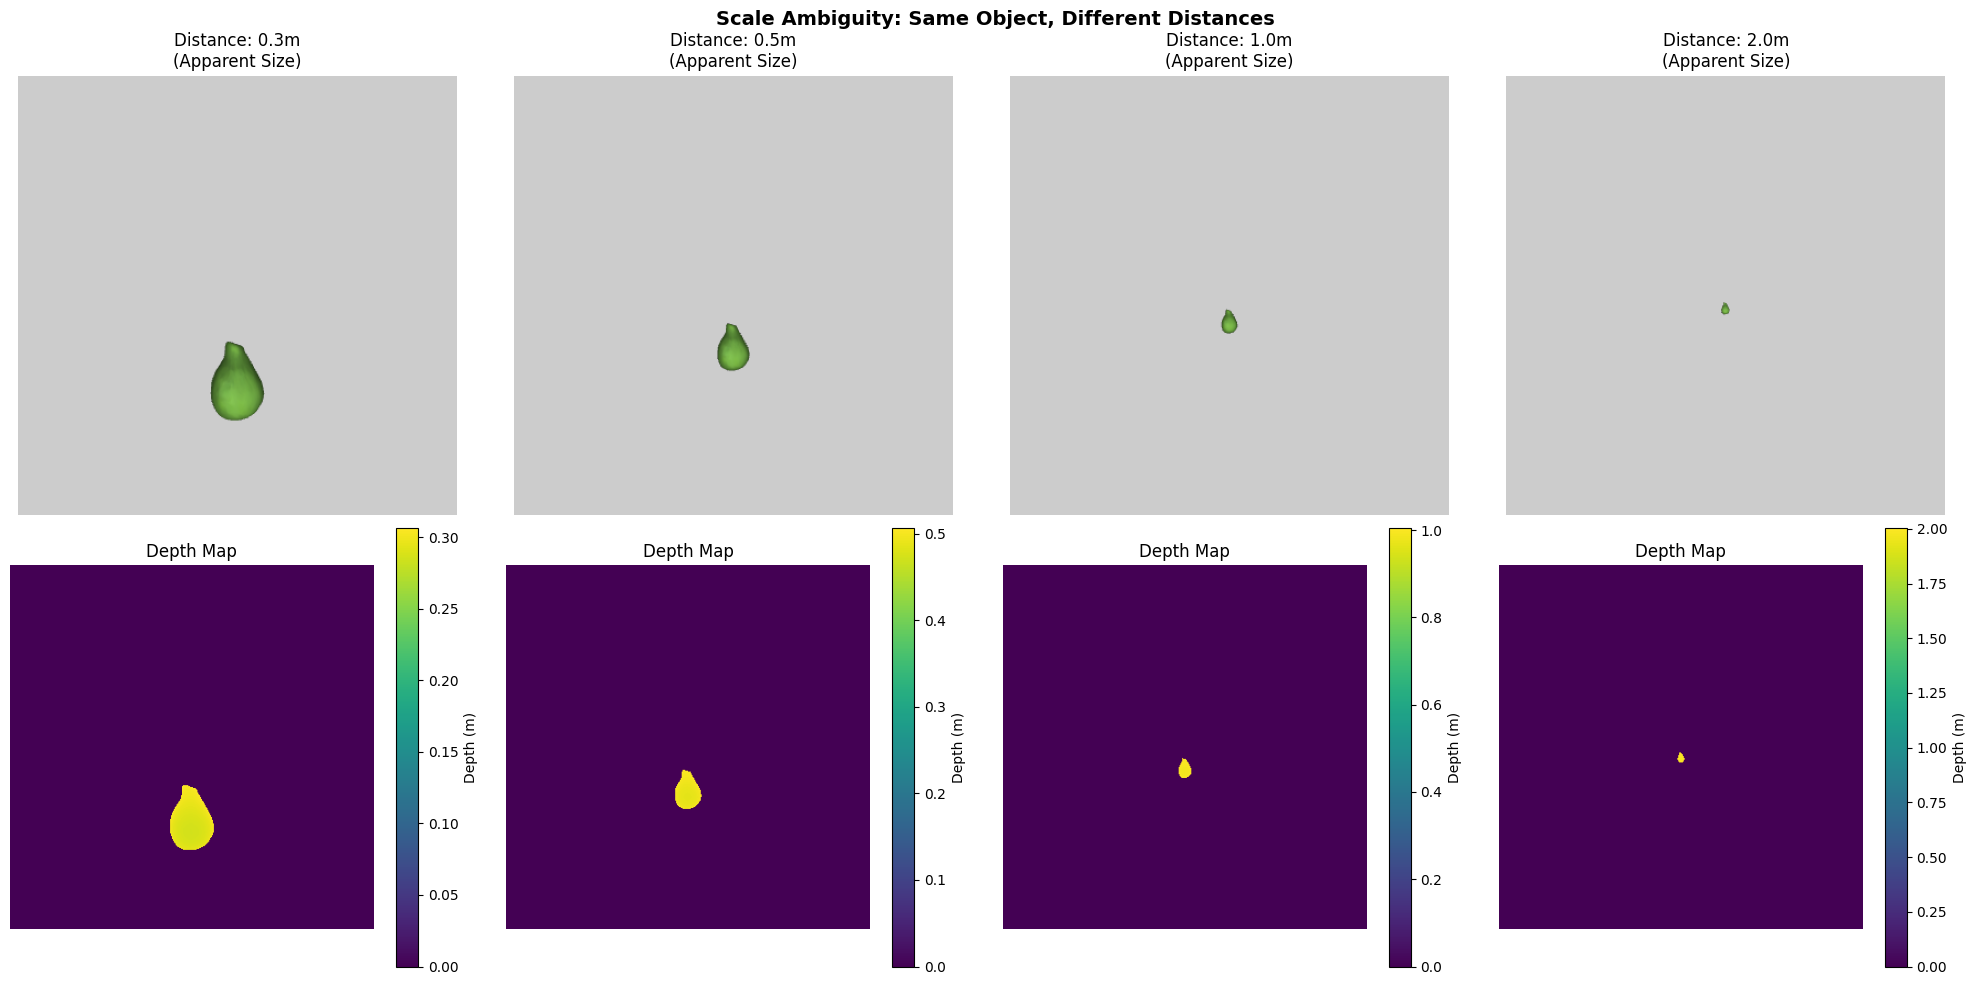

✓ Scale ambiguity simulation complete!



In [12]:
# Test with your downloaded avocado model
mesh_path = os.path.join(DATA_DIR, "avocado.glb")

# Quick test - single render
color, depth = render_at_distance(mesh_path, distance_meters=1.0)
visualize_renders(color, depth, distance=1.0, title="Avocado")

# Full scale ambiguity demonstration
results = simulate_scale_ambiguity(
    mesh_path, 
    distances=[0.3, 0.5, 1.0, 2.0]  # Close to far
)

In [15]:
import torch
import torch.nn as nn
from torchvision import models

# ============================================================================
# PART 0: MODEL BLUEPRINT (Must match the training code exactly)
# ============================================================================

class ResNetUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1. Encoder: ResNet-50
        res = models.resnet50(weights='IMAGENET1K_V2')

        self.enc0 = nn.Sequential(res.conv1, res.bn1, res.relu)
        self.pool = res.maxpool
        self.e1, self.e2, self.e3, self.e4 = res.layer1, res.layer2, res.layer3, res.layer4

        # 2. Decoder: U-Net layers
        self.up4 = nn.ConvTranspose2d(2048, 1024, 2, 2)
        self.c4 = nn.Sequential(nn.Conv2d(2048, 1024, 3, 1, 1), nn.ReLU(True))
        
        self.up3 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.c3 = nn.Sequential(nn.Conv2d(1024, 512, 3, 1, 1), nn.ReLU(True))
        
        self.up2 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.c2 = nn.Sequential(nn.Conv2d(512, 256, 3, 1, 1), nn.ReLU(True))
        
        self.up1 = nn.ConvTranspose2d(256, 64, 2, 2)
        self.c1 = nn.Sequential(nn.Conv2d(128, 64, 3, 1, 1), nn.ReLU(True))
        
        self.up0 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.c0 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(True))
        
        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        # Encoder Path
        s0  = self.enc0(x)
        s0p = self.pool(s0)
        s1  = self.e1(s0p)
        s2  = self.e2(s1)
        s3  = self.e3(s2)
        b   = self.e4(s3)

        # Decoder Path
        d = self.up4(b);  d = torch.cat([d, s3], 1); d = self.c4(d)
        d = self.up3(d);  d = torch.cat([d, s2], 1); d = self.c3(d)
        d = self.up2(d);  d = torch.cat([d, s1], 1); d = self.c2(d)
        d = self.up1(d);  d = torch.cat([d, s0], 1); d = self.c1(d)
        d = self.up0(d);  d = self.c0(d)
        return self.out(d)

print("✅ Model architecture defined.")

✅ Model architecture defined.


Device: cuda
Data Directory: /home/ubuntu/nutrition_data/data_phase3_scale
✅ Loaded model from checkpoints_tesla_final/BEST_TESLA.pth

GENERATING SYNTHETIC TEST SCENES

SCALE AMBIGUITY SIMULATION

Rendering at 0.3m distance...
  ✓ Image shape: (400, 400, 3)
  ✓ Depth range: 0.000m to 0.307m
  ✓ Mean depth: 0.294m

Rendering at 0.5m distance...
  ✓ Image shape: (400, 400, 3)
  ✓ Depth range: 0.000m to 0.507m
  ✓ Mean depth: 0.494m

Rendering at 1.0m distance...
  ✓ Image shape: (400, 400, 3)
  ✓ Depth range: 0.000m to 1.006m
  ✓ Mean depth: 0.994m

Rendering at 1.5m distance...
  ✓ Image shape: (400, 400, 3)
  ✓ Depth range: 0.000m to 1.506m
  ✓ Mean depth: 1.495m

Rendering at 2.0m distance...
  ✓ Image shape: (400, 400, 3)
  ✓ Depth range: 0.000m to 2.006m
  ✓ Mean depth: 1.995m



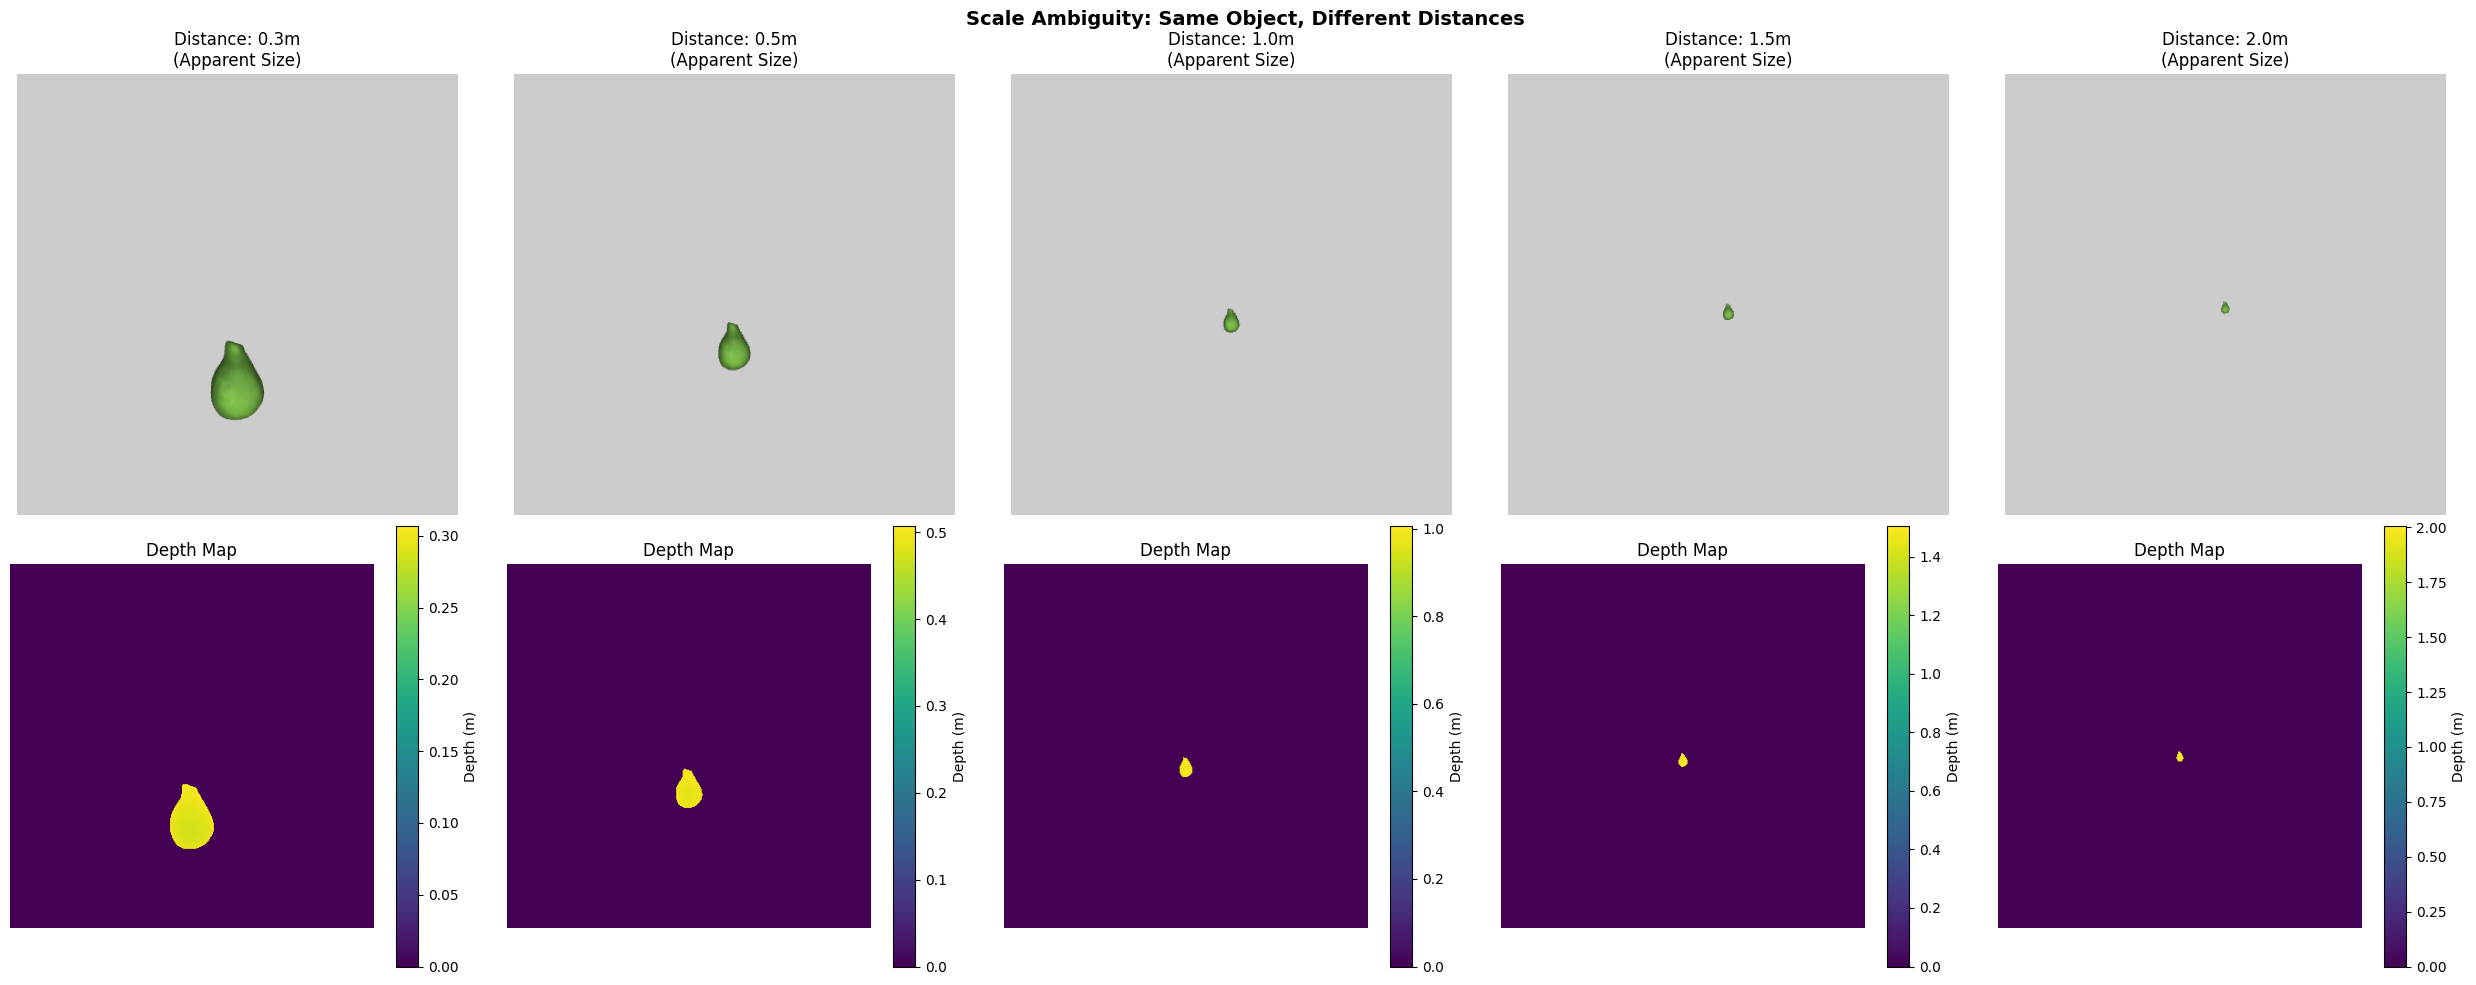

✓ Scale ambiguity simulation complete!


HARDWARE-SOFTWARE FUSION EXPERIMENT

Simulating 50 sparse depth points from ARCore/LiDAR
Model running on: cuda

────────────────────────────────────────────────────────────
Distance: 0.3m
────────────────────────────────────────────────────────────
  AI Only (Uncalibrated):
    • MAPE:  1119.15%
    • RMSE:  3.289m

  Hardware Fusion:
    • Scale Factor (α): 0.0818
    • Sensor Points:    50
    • MAPE:  2.49%
    • RMSE:  0.009m
    • Improvement: 99.8%

────────────────────────────────────────────────────────────
Distance: 0.5m
────────────────────────────────────────────────────────────
  AI Only (Uncalibrated):
    • MAPE:  634.43%
    • RMSE:  3.134m

  Hardware Fusion:
    • Scale Factor (α): 0.1359
    • Sensor Points:    50
    • MAPE:  2.27%
    • RMSE:  0.013m
    • Improvement: 99.6%

────────────────────────────────────────────────────────────
Distance: 1.0m
────────────────────────────────────────────────────────────
  AI Only (Unc

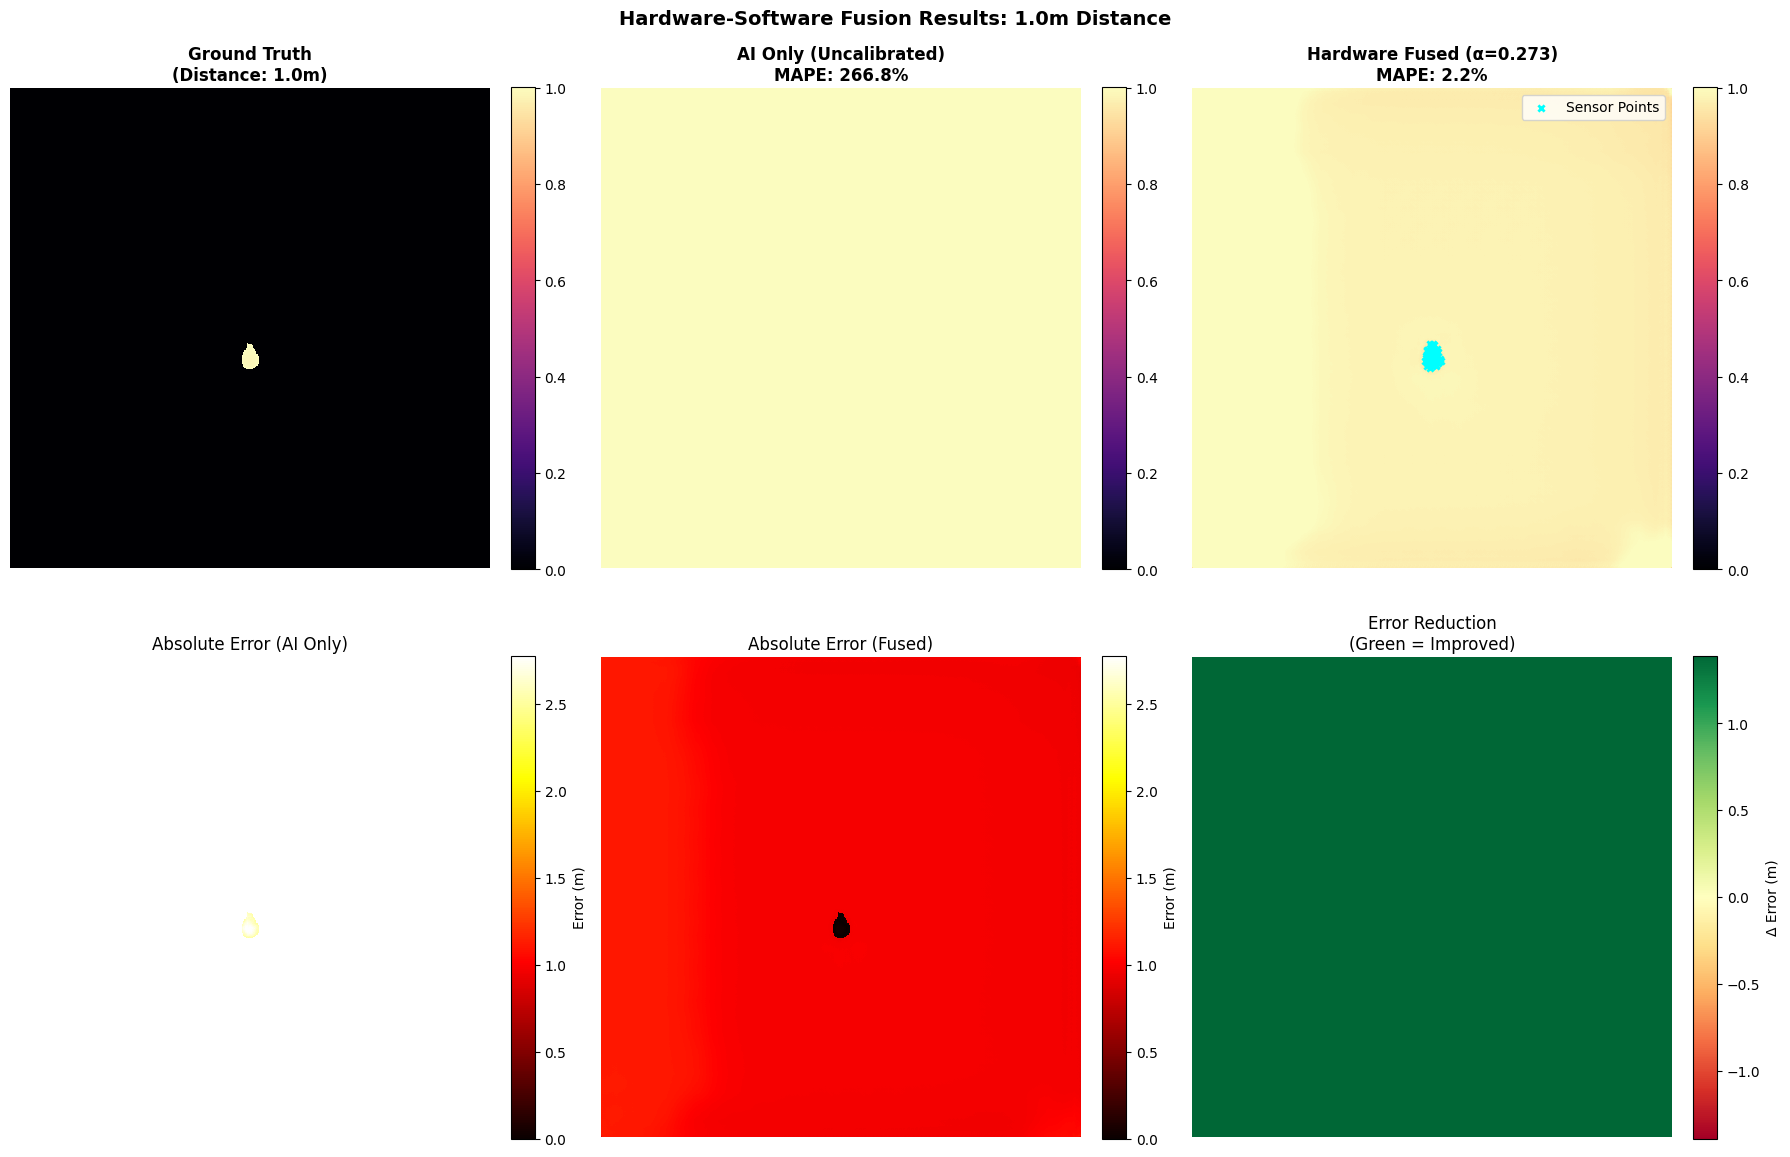

────────────────────────────────────────────────────────────
Distance: 1.5m
────────────────────────────────────────────────────────────
  AI Only (Uncalibrated):
    • MAPE:  144.34%
    • RMSE:  2.158m

  Hardware Fusion:
    • Scale Factor (α): 0.4082
    • Sensor Points:    50
    • MAPE:  1.55%
    • RMSE:  0.027m
    • Improvement: 98.9%



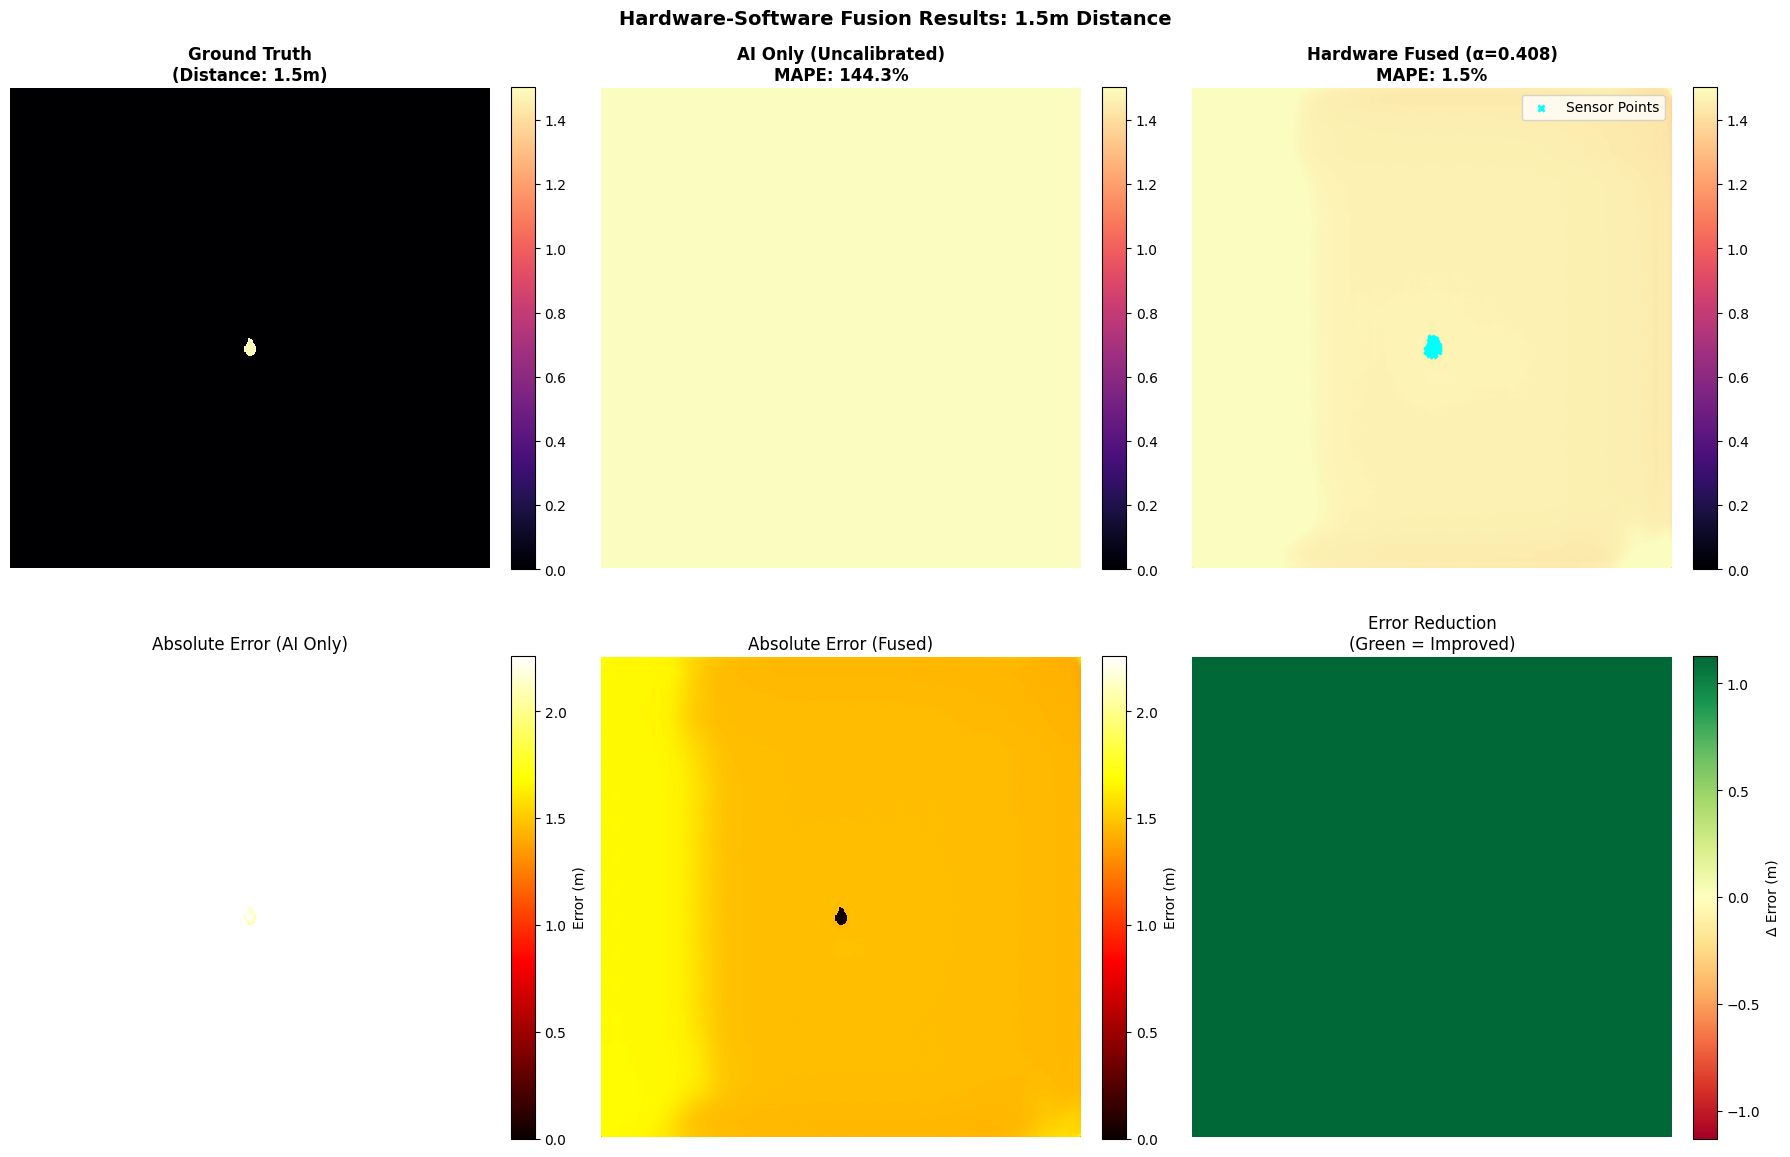

────────────────────────────────────────────────────────────
Distance: 2.0m
────────────────────────────────────────────────────────────
  AI Only (Uncalibrated):
    • MAPE:  83.75%
    • RMSE:  1.671m

  Hardware Fusion:
    • Scale Factor (α): 0.5438
    • Sensor Points:    50
    • MAPE:  1.20%
    • RMSE:  0.029m
    • Improvement: 98.6%



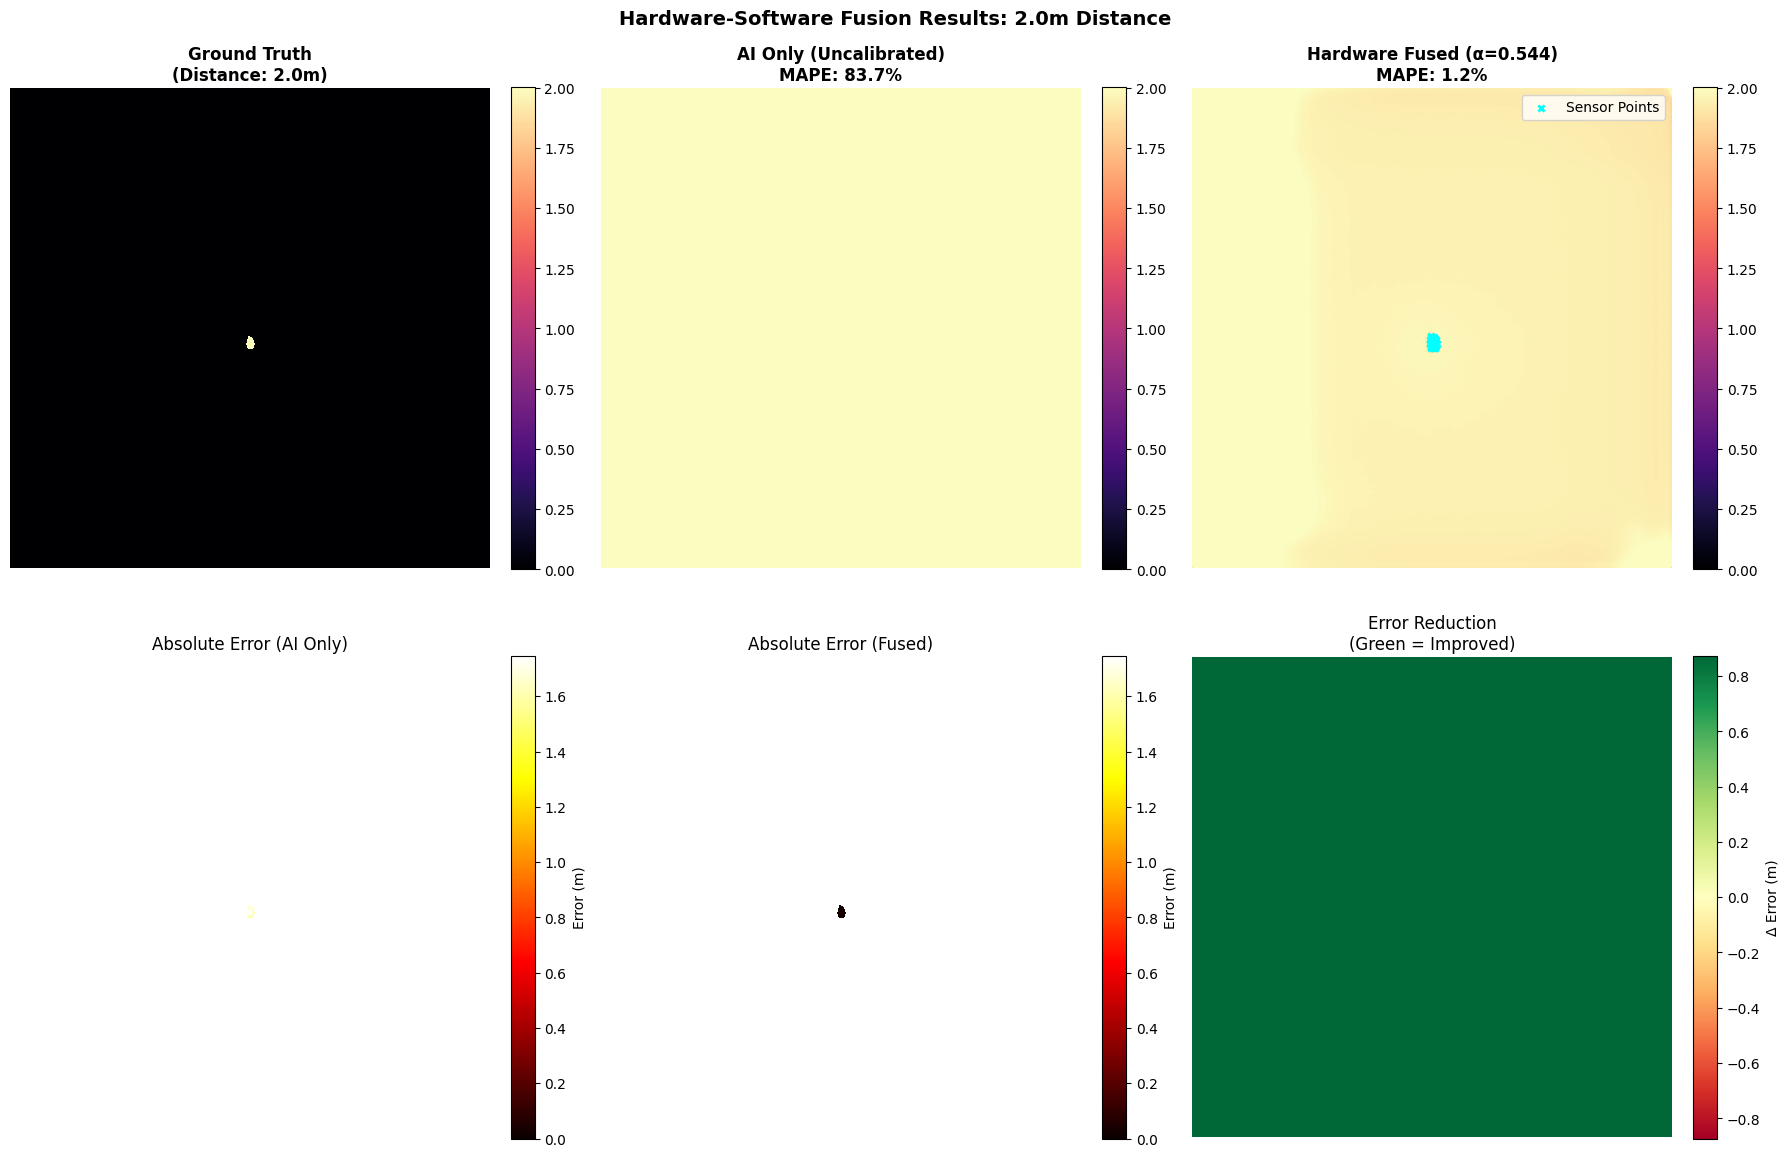

✅ EXPERIMENT COMPLETE


SUMMARY: Hardware Fusion Improvements
Distance 0.3m: 1119.2% → 2.5% (+99.8% improvement)
Distance 0.5m: 634.4% → 2.3% (+99.6% improvement)
Distance 1.0m: 266.8% → 2.2% (+99.2% improvement)
Distance 1.5m: 144.3% → 1.5% (+98.9% improvement)
Distance 2.0m: 83.7% → 1.2% (+98.6% improvement)

Average Error Reduction: 99.2%

✅ All visualizations saved to current directory


In [16]:

import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ============================================================================
# PART 1: FUNCTION DEFINITIONS (The Toolbox)
# ============================================================================

def load_model(model_path, model_class, device):
    """Safely loads a model checkpoint."""
    model = model_class().to(device)
    
    if os.path.exists(model_path):
        try:
            model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
            print(f"✅ Loaded model from {model_path}")
            return model, True
        except Exception as e:
            print(f"⚠️ Error loading model: {e}")
            print("⚠️ Using random weights for demonstration.")
            return model, False
    else:
        print("⚠️ Warning: Model checkpoint not found. Using random weights for demonstration.")
        return model, False


def preprocess_for_model(img_array, target_size=(480, 480)):
    """Prepares the rendered image for the PyTorch model."""
    if img_array.dtype != np.uint8:
        img_array = (np.clip(img_array, 0, 255)).astype(np.uint8)
    
    img_resized = cv2.resize(img_array, target_size)
    img_tensor = torch.from_numpy(img_resized.transpose(2, 0, 1)).float() / 255.0
    
    return img_tensor.unsqueeze(0), img_resized


def solve_scale_factor(pred_depth, true_sparse_depth, min_points=10):
    """
    Calculates optimal scale factor alpha where: True = alpha * Pred
    Formula: alpha = sum(pred * true) / sum(pred^2)
    """
    x = pred_depth.flatten()
    y = true_sparse_depth.flatten()
    
    mask = (y > 0.001) & (x > 0.001) & np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    
    if len(x) < min_points:
        print(f"  ⚠️ Warning: Only {len(x)} valid points for calibration")
        return 1.0
    
    alpha = np.sum(x * y) / np.sum(x ** 2)
    return alpha


def simulate_sparse_sensor(gt_depth, num_points=50, method='random'):
    """Simulates sparse depth points from ARCore/LiDAR/ToF sensors."""
    valid_mask = (gt_depth > 0.001) & np.isfinite(gt_depth)
    y_coords, x_coords = np.where(valid_mask)
    
    if len(y_coords) == 0:
        return np.array([]), np.array([]), np.array([])
    
    if len(y_coords) > num_points:
        if method == 'random':
            idx = np.random.choice(len(y_coords), num_points, replace=False)
        else:
            step = len(y_coords) // num_points
            idx = np.arange(0, len(y_coords), step)[:num_points]
        
        sparse_y, sparse_x = y_coords[idx], x_coords[idx]
    else:
        sparse_y, sparse_x = y_coords, x_coords
    
    sensor_values = gt_depth[sparse_y, sparse_x]
    return sparse_y, sparse_x, sensor_values


def visualize_fusion_result(gt_depth, pred_uncal, pred_fused, 
                            sparse_y, sparse_x,
                            distance, mape_before, mape_after, alpha):
    """Creates detailed visualization of fusion results."""
    
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    vmax = np.percentile(gt_depth[gt_depth > 0], 95)
    
    # Row 1: Depth Maps
    im0 = axs[0, 0].imshow(gt_depth, cmap='magma', vmin=0, vmax=vmax)
    axs[0, 0].set_title(f"Ground Truth\n(Distance: {distance}m)", fontsize=12, fontweight='bold')
    axs[0, 0].axis('off')
    plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)
    
    im1 = axs[0, 1].imshow(pred_uncal, cmap='magma', vmin=0, vmax=vmax)
    axs[0, 1].set_title(f"AI Only (Uncalibrated)\nMAPE: {mape_before:.1f}%", 
                        fontsize=12, fontweight='bold')
    axs[0, 1].axis('off')
    plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)
    
    im2 = axs[0, 2].imshow(pred_fused, cmap='magma', vmin=0, vmax=vmax)
    axs[0, 2].scatter(sparse_x, sparse_y, c='cyan', s=20, marker='x', 
                     linewidths=2, label='Sensor Points')
    axs[0, 2].set_title(f"Hardware Fused (α={alpha:.3f})\nMAPE: {mape_after:.1f}%", 
                       fontsize=12, fontweight='bold')
    axs[0, 2].axis('off')
    axs[0, 2].legend(loc='upper right', fontsize=10)
    plt.colorbar(im2, ax=axs[0, 2], fraction=0.046, pad=0.04)
    
    # Row 2: Error Maps
    valid_mask = gt_depth > 0.001
    error_uncal = np.abs(pred_uncal - gt_depth)
    error_fused = np.abs(pred_fused - gt_depth)
    error_max = np.percentile(error_uncal[valid_mask], 95)
    
    im3 = axs[1, 0].imshow(error_uncal, cmap='hot', vmin=0, vmax=error_max)
    axs[1, 0].set_title("Absolute Error (AI Only)", fontsize=12)
    axs[1, 0].axis('off')
    plt.colorbar(im3, ax=axs[1, 0], fraction=0.046, pad=0.04, label='Error (m)')
    
    im4 = axs[1, 1].imshow(error_fused, cmap='hot', vmin=0, vmax=error_max)
    axs[1, 1].set_title("Absolute Error (Fused)", fontsize=12)
    axs[1, 1].axis('off')
    plt.colorbar(im4, ax=axs[1, 1], fraction=0.046, pad=0.04, label='Error (m)')
    
    error_reduction = error_uncal - error_fused
    im5 = axs[1, 2].imshow(error_reduction, cmap='RdYlGn', 
                          vmin=-error_max*0.5, vmax=error_max*0.5)
    axs[1, 2].set_title("Error Reduction\n(Green = Improved)", fontsize=12)
    axs[1, 2].axis('off')
    plt.colorbar(im5, ax=axs[1, 2], fraction=0.046, pad=0.04, label='Δ Error (m)')
    
    plt.suptitle(f"Hardware-Software Fusion Results: {distance}m Distance", 
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(f"fusion_result_{distance}m.png", dpi=150, bbox_inches='tight')
    plt.show()


def run_fusion_experiment(model, results, device, num_sensor_points=50):
    """
    Main experiment: Compare AI-only vs Hardware-Fused depth estimation.
    """
    print(f"\n{'='*60}")
    print("HARDWARE-SOFTWARE FUSION EXPERIMENT")
    print(f"{'='*60}\n")
    print(f"Simulating {num_sensor_points} sparse depth points from ARCore/LiDAR")
    print(f"Model running on: {device}\n")
    
    experiment_results = []
    
    for color, gt_depth, distance in results:
        
        # 1. RUN AI INFERENCE
        input_tensor, img_resized = preprocess_for_model(color)
        input_tensor = input_tensor.to(device)
        
        with torch.no_grad():
            pred_raw = model(input_tensor)
            gt_resized = cv2.resize(gt_depth, 
                                   (pred_raw.shape[3], pred_raw.shape[2]), 
                                   interpolation=cv2.INTER_NEAREST)
            pred_depth = pred_raw[0, 0].cpu().numpy()
        
        # 2. CALCULATE UNCALIBRATED ERROR
        valid_mask = (gt_resized > 0.001) & np.isfinite(gt_resized)
        
        if valid_mask.sum() == 0:
            print(f"⚠️ Skipping distance {distance}m - no valid depth points")
            continue
        
        safe_gt = np.maximum(gt_resized, 0.001)
        error_map_before = np.abs(pred_depth - gt_resized)
        mape_before = np.mean(error_map_before[valid_mask] / safe_gt[valid_mask]) * 100
        rmse_before = np.sqrt(np.mean(error_map_before[valid_mask] ** 2))
        
        # 3. SIMULATE HARDWARE FUSION
        sparse_y, sparse_x, sensor_points = simulate_sparse_sensor(
            gt_resized, num_points=num_sensor_points, method='random'
        )
        
        if len(sparse_y) >= 10:
            ai_points = pred_depth[sparse_y, sparse_x]
            alpha = solve_scale_factor(ai_points, sensor_points)
            pred_fused = pred_depth * alpha
            
            error_map_after = np.abs(pred_fused - gt_resized)
            mape_after = np.mean(error_map_after[valid_mask] / safe_gt[valid_mask]) * 100
            rmse_after = np.sqrt(np.mean(error_map_after[valid_mask] ** 2))
            improvement = ((mape_before - mape_after) / mape_before) * 100
        else:
            alpha = 1.0
            pred_fused = pred_depth
            mape_after = mape_before
            rmse_after = rmse_before
            improvement = 0.0
        
        # 4. REPORT RESULTS
        print(f"{'─'*60}")
        print(f"Distance: {distance}m")
        print(f"{'─'*60}")
        print(f"  AI Only (Uncalibrated):")
        print(f"    • MAPE:  {mape_before:.2f}%")
        print(f"    • RMSE:  {rmse_before:.3f}m")
        print(f"\n  Hardware Fusion:")
        print(f"    • Scale Factor (α): {alpha:.4f}")
        print(f"    • Sensor Points:    {len(sparse_y)}")
        print(f"    • MAPE:  {mape_after:.2f}%")
        print(f"    • RMSE:  {rmse_after:.3f}m")
        print(f"    • Improvement: {improvement:.1f}%")
        print()
        
        experiment_results.append({
            'distance': distance,
            'mape_before': mape_before,
            'mape_after': mape_after,
            'rmse_before': rmse_before,
            'rmse_after': rmse_after,
            'alpha': alpha,
            'improvement': improvement
        })
        
        # 5. VISUALIZE
        if distance >= 1.0:
            visualize_fusion_result(
                gt_resized, pred_depth, pred_fused,
                sparse_y, sparse_x,
                distance, mape_before, mape_after, alpha
            )
    
    print(f"{'='*60}")
    print("✅ EXPERIMENT COMPLETE")
    print(f"{'='*60}\n")
    
    return experiment_results


# ============================================================================
# PART 2: EXECUTION (Actually Run the Experiment)
# ============================================================================

if __name__ == "__main__":
    # Setup
    PROJECT_ROOT = "/home/ubuntu/nutrition_data"
    DATA_DIR = os.path.join(PROJECT_ROOT, "data_phase3_scale")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Device: {device}")
    print(f"Data Directory: {DATA_DIR}")
    
    # Load Model (assumes ResNetUNet is already defined in your notebook)
    model, loaded = load_model(
        model_path="checkpoints_tesla_final/BEST_TESLA.pth",
        model_class=ResNetUNet,  # Your model class must be defined
        device=device
    )
    model.eval()
    
    # Generate Synthetic Test Data
    # (assumes simulate_scale_ambiguity() and render_at_distance() are already defined)
    mesh_path = os.path.join(DATA_DIR, "avocado.glb")
    
    print("\n" + "="*60)
    print("GENERATING SYNTHETIC TEST SCENES")
    print("="*60)
    
    results = simulate_scale_ambiguity(
        mesh_path=mesh_path,
        distances=[0.3, 0.5, 1.0, 1.5, 2.0]
    )
    
    # Run Fusion Experiment
    experiment_results = run_fusion_experiment(
        model=model,
        results=results,
        device=device,
        num_sensor_points=50
    )
    
    # Summary Statistics
    print("\n" + "="*60)
    print("SUMMARY: Hardware Fusion Improvements")
    print("="*60)
    
    for res in experiment_results:
        improvement = res['improvement']
        print(f"Distance {res['distance']}m: "
              f"{res['mape_before']:.1f}% → {res['mape_after']:.1f}% "
              f"({improvement:+.1f}% improvement)")
    
    avg_improvement = np.mean([r['improvement'] for r in experiment_results])
    print(f"\nAverage Error Reduction: {avg_improvement:.1f}%")
    print("\n✅ All visualizations saved to current directory")